In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import signal


plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,7)
plt.rcParams['agg.path.chunksize'] = 10000

# Problem 1: Shifting

In order to shift an array by an arbitrary amount, one can convolve the array with a phase factor, as shown in shift_fun. First, the array is fourier transformed. Then a phase factor is created as:

$$exp\left(\frac{2 \pi i k dx}{N}\right)$$

Where $N$ is the length of the array, or number of points, $k \in [0, N-1]$, and $dx$ is the arbitrary shift to perform.

Then, to actually perform the shift, we convolve the array with the this phase factor and return the convolved array in real space by performing an inverse fourier transform. 

The figure below shows a gaussian shifted by half of the array length. We see the period nature of the fourier transform, as this makes it so half of the gaussian appears at the end of the array and half of it at the very beginning. 

In [2]:
def shift_fun(arr, shift):
    
    N = len(arr)
    arrft = np.fft.fft(arr)
    k=np.arange(N)
    phase = np.exp(2*np.pi*1J*k*shift/N)
    arr_shift = np.fft.ifft(arrft * phase)
    
    return arr_shift
    

In [3]:
x = np.linspace(-10,10,1000)
gauss = np.exp(-x**2)  # gaussian centered at 0
gauss_shift = shift_fun(gauss, len(gauss)/2)  # gaussian shifted by half the length of the array

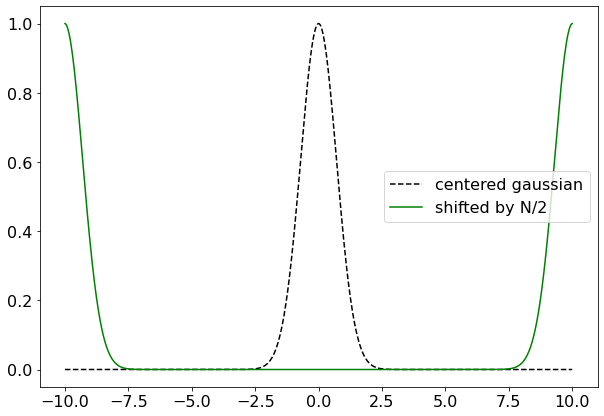

In [4]:
plt.plot(x, gauss, '--', color='black', label='centered gaussian')
plt.plot(x, np.real(gauss_shift), color='green', label='shifted by N/2')
plt.legend()
plt.show()

# Problem 2: Correlation

## a)

The function correlate_fun() below takes in 2 arrays and returns their correlation function. In order to do this, we fourier transform both of the arrays and multiply the first one by the complex conjugate of the second one in fourier space. Then we return the inverse fourier transform of that product. Below we show the correlation function of a gaussian with itself. 

In [5]:
def correlate_fun(arr1, arr2):
    
    arr1ft = np.fft.fft(arr1)
    arr2ft = np.fft.fft(arr2)
    corr = np.fft.ifft(arr1ft * np.conj(arr2ft))
    return corr

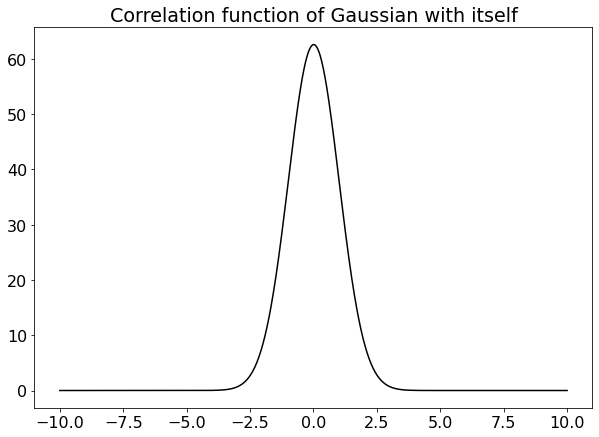

In [6]:
corr_gauss = correlate_fun(gauss, gauss)
plt.plot(x, np.real(np.fft.fftshift(corr_gauss)), color='black')
plt.title('Correlation function of Gaussian with itself')
plt.show()

## b)

using these results, write a routine to take the correlation function
of a Gaussian (shifted by an arbitrary amount) with itself. How does the
correlation function depend on the shift? Does this surprise you?

Now we use the same script to find the correlation function of a Gaussian that has been shifted by an arbitrary amount with itself. We use the shift_fun from the part above to shift the Gaussian. The plot below shows that the correlation function is independent of the shift we choose for the gaussian. We see that the correlation functions of all cases overlap with each other and agree perfectly with the correlation function of a gaussian with itself (with no shift). This doesn't surpise me because the correlation of a function is given by:

$$h(x) = \int f(x)g(x + dx)$$

In this case, $f$ and $g$ are the same (i.e. the shifted Gaussian).

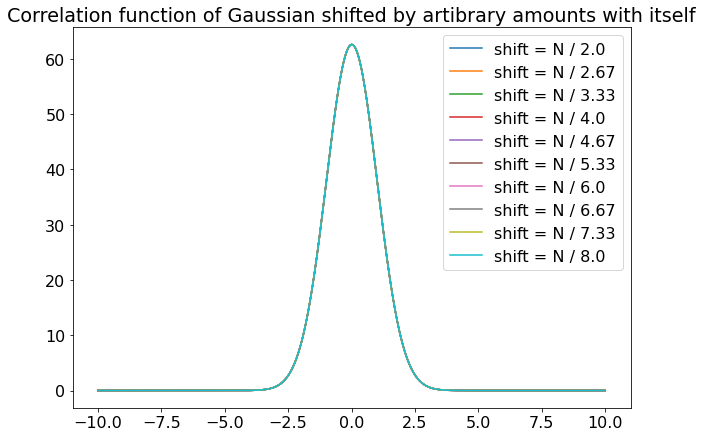

In [7]:
shifts = np.linspace(2, 8, 10)
for i in shifts:
    gauss_shift_ = shift_fun(gauss, len(gauss)/i)
    conv_ = correlate_fun(gauss_shift_, gauss_shift_)
    plt.plot(x, np.real(np.fft.fftshift(conv_)), label='shift = N / {}'.format(round(i, 2)))
plt.title('Correlation function of Gaussian shifted by artibrary amounts with itself')
plt.legend()
plt.show()

# Problem 3: Convolution

Because the fft assumes that the data is periodic, if you try to take the fourier transform of data with different values at the beginning and end of the data, power is sprayed into values of k (and likely high values of k) where you don't actually have power in the real data. In order to deal with this, a window function can be used, or zeros can be artificially added to the edges of the array to ensure that there is a continuity in the wrap-around version of the data. 

The function convolve_fun() takes in 2 arrays and returns their convolution. I use the method np.pad to add zeros at the ends of the arrays to avoid the wrapping around issue. I then return the convolution after removing the padding I added in the first place.

The plots below show an example of a convolution of spikes with gaussians and we see there is no issue with wrap-arounds.

In [8]:
def convolve_fun(arr1, arr2):
    
    arr1_pad = np.pad(arr1, (2, 2), 'constant', constant_values=(0, 0))
    arr2_pad = np.pad(arr2, (2, 2), 'constant', constant_values=(0, 0))
    
    ft1 = np.fft.fft(arr1_pad)
    ft2 = np.fft.fft(arr2_pad)
    
    conv = np.fft.ifft(ft1 * ft2)
    
    conv = np.delete(conv, [0,1,-1,-2])
    
    return conv

In [9]:
N = 1000

# first array is an array of spikes
f = np.zeros(N)
a = 100
f[::a] = 1

x = np.linspace(-10,10,N//10)
xs = np.concatenate((x, x, x, x, x, x, x, x, x, x))
g2 = np.exp(-xs**2)
#b=int(1*a)  #the width of our sawteeth
#g[:b]=np.linspace(1,0,b)

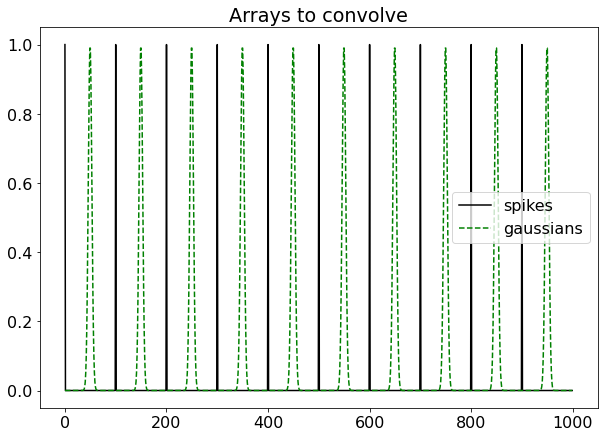

In [10]:
plt.plot(f, color='black', label='spikes')
plt.plot(g2, '--', color='green', label='gaussians')
plt.legend()
plt.title('Arrays to convolve')
plt.show()

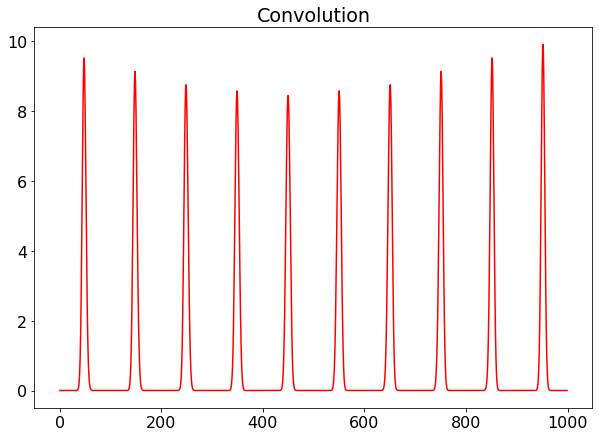

In [11]:
plt.plot(np.real(convolve_fun(f, g2)), color='red')
plt.title('Convolution')
plt.show()

# Problem 4: Discrete Fourier Transforms

## a)

We want to show that:

$$\sum_{x=0}^{N-1} exp(-2 \pi i k x / N) = \frac{1 - exp(-2 \pi i k)}{1 - exp(-2 \pi i k / N)}$$

If we take $\alpha = exp(-2 \pi i k / N)$, then $exp(-2 \pi i k x / N) = \alpha^x$ and we can rewrite the sum as:

$$\sum_{x=0}^{N-1} \alpha^x = \sum_{x=1}^{N} \alpha^{x-1}$$

Then, using the fact that this is the sum of a geometric series with $ |\alpha| \leq 1$, we can use the equation

$$S_N = \frac{a(1-r^N)}{1-r}$$

And here, given that there is no explicit $a$, we call $a = 1$ and $r = \alpha$, so:

$$S_N = 1 \times \frac{1 - exp(-2 \pi i k / N)^N}{1 - exp(-2 \pi i k / N)} = \frac{1 - exp(-2 \pi i k)}{1 - exp(-2 \pi i k / N)}$$

$$\longrightarrow \sum_{x=0}^{N-1} exp(-2 \pi i k x / N) = \frac{1 - exp(-2 \pi i k)}{1 - exp(-2 \pi i k / N)}$$

## b)

We look at the limit as $k$ approaches 0 of this expression. 

$$\lim_{k\to0} \frac{1 - exp(-2 \pi i k)}{1 - exp(-2 \pi i k / N)} = \frac{0}{0}$$

Since we have an indeterminate form, we use L'Hopitals rule and take the derivative of numerator and denominator separately.

$$\lim_{k\to0} \frac{1 - exp(-2 \pi i k)}{1 - exp(-2 \pi i k / N)} = \lim_{k\to0} \frac{2\pi i exp(-2 \pi i k)}{\frac{2\pi i}{N}exp(-2 \pi i k / N)} = \frac{2\pi i}{\frac{2\pi i}{N}} = N$$

$$\longrightarrow \lim_{k\to0} \sum_{x=0}^{N-1} exp(-2 \pi i k x / N) = N$$

Now we want to look at what happens when $k$ is and isn't a multiple of $N$.

Firstly, the numerator of the fraction is $1 - exp(-2\pi i k)$, and for any $k \in \mathbb{Z}^+$, $exp(-2\pi i k) = 1$, so $1 - exp(-2\pi i k) = 0$. And we see that the numerator is $0$ no matter what. 

Now, we look at the demoninator of the expression and we have 2 options:

1. If $k = aN \rightarrow \frac{k}{N} = a$ for some $a \in \mathbb{Z}^+$. Then
$$1 - exp(-2\pi i k / N) =1 - exp(-2\pi i a) = 1-1 = 0$$
In this case, both the numerator and denominator are $0$, as so we have an indeterminate form which is not mathematically equivalent to $0$.

$$\ \ \ \ \ $$

2. If $k$ is not a multiple of $N$, then we will get
$$1 - exp(-2\pi i k / N) =1 - exp(-2\pi i b) \neq 0$$

Since $b \notin  \mathbb{Z}^+$. Then we have a finite, non-zero value on the denominator and $0$ for the numerator, which means the whole expressions evaluates to $0$.

$$\ \ \ \ \ $$

In conclusion, we see that the discrete fourier transform is $0$ if $k$ is not a multiple of $N$ and is not equal to $0$ otherwise. 

## c)

For this part, I chose to find the fourier transform of 2 pure sine waves, one with an integer number of periods and one with a non-integer number of periods. In the final plot of this section, we see that for the integer sin, we have something that looks very similar to a delta function peaking at a single point in fourier space. Conversely, when using both the analytic and numpy's fft methods, we get a wider peak and we see that the amplitude is actually distributed amongst a few modes surrounding the one with highest amplitude, looking a lot less like a delta function. In addition, we see that even far from the peak of the fft, we have a non-zero amplitude when the wave has a non-integer period and is unwindowed.

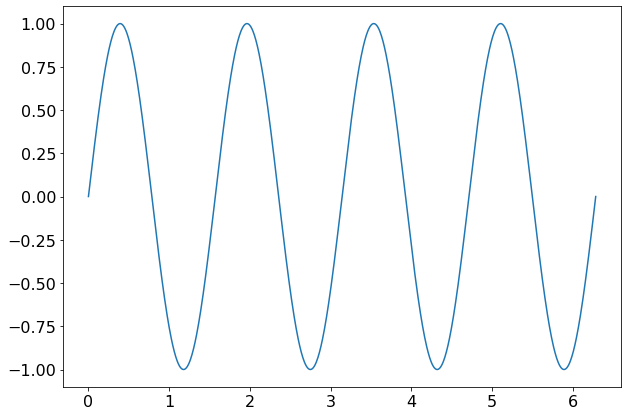

In [12]:
# choosing a k that is a multiple of N so that we get an integer sine wave
k = 200
N_ = 50
x = np.linspace(0, 2*np.pi, 1000)

df = 1/len(x)
f = np.arange(len(x))*df

int_sin = np.sin(k*x/N_)
int_ft = np.fft.fft(int_sin)

plt.plot(x, int_sin)
plt.show()

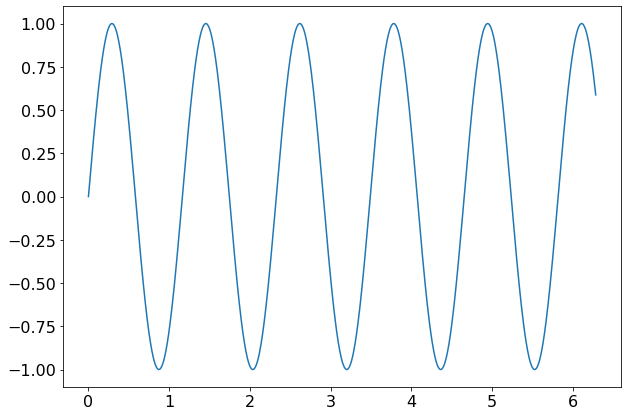

In [13]:
# choosing a k that is a multiple of N so that we get an integer sine wave
kn = 270
N_ = 50
x = np.linspace(0, 2*np.pi, 1000)
nint_sin = np.sin(kn*x/N_)
nint_ft = np.fft.fft(nint_sin)
plt.plot(x, nint_sin)
plt.show()

In [14]:
fun = nint_sin
_k = np.arange(len(fun)).reshape((len(fun), 1))
_x = np.arange(len(fun))
term = np.exp(-2*np.pi*1j*_k*_x/len(fun))
analytical = np.dot(term, fun)

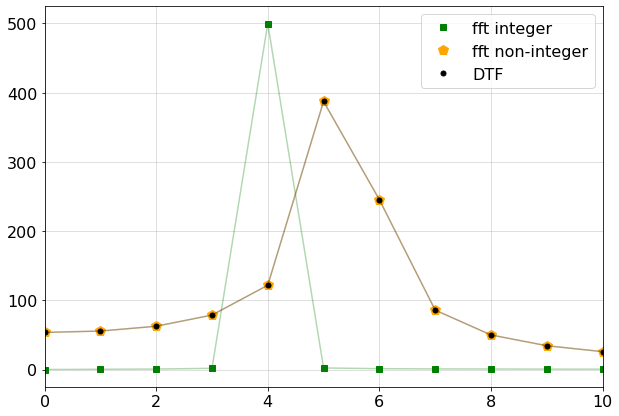

In [15]:
plt.plot(np.abs(int_ft), 's', color='green', label='fft integer')
plt.plot(np.abs(int_ft),  color='green', alpha=0.3)
plt.plot(np.abs(nint_ft), 'p', ms=10, color='orange', label='fft non-integer')
plt.plot(np.abs(nint_ft), color='orange', alpha=0.3)
plt.plot(np.abs(analytical), '.', color='black', ms=10, label='DTF')
plt.plot(np.abs(analytical), color='black', alpha=0.3)
plt.xlim(0,10)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# d)

Using a window function, we can can ensure that a discontinuous jump doesn't happen at the edges of our data. The window function used here is 

$$w(x) = 0.5 - 0.5cos(2\pi x / N), \ \ \ \ \ \ \ \  0 \leq x \leq N$$

Which is zero at the edges and 1 at the center. 

The plot below shows that if we multiply the non-integer wave with the window function (convolve it in fourier space), we improve the spectral leakage. Even though there is still some power in other frequencies, those have decreased by a significant amount. Even though the peak still seems fairly distributed, we see that far from the peak we quickly drop to an amplitude of 0, which is closer to what we would get from an integer period sine wave. 

In [16]:
x_ = np.linspace(0, N, N)
win = 0.5 - 0.5*np.cos(2*np.pi*x_/N)

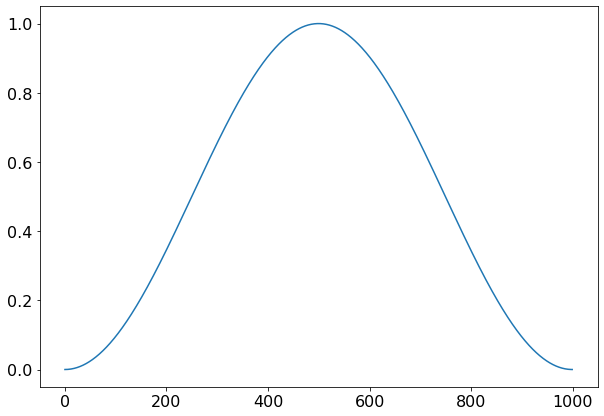

In [17]:
plt.plot(win)
plt.show()

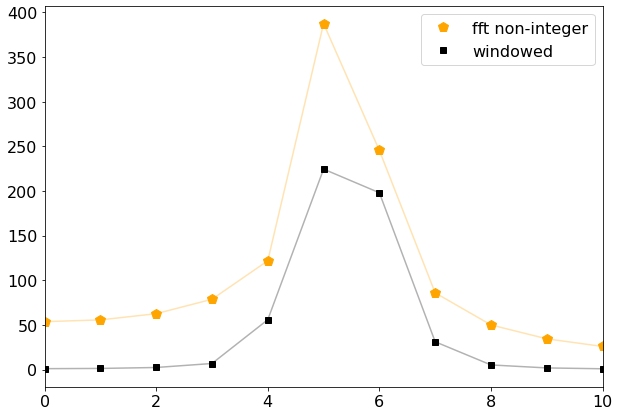

In [18]:
win_ft = np.fft.fft(nint_sin * win)

plt.plot(np.abs(nint_ft), 'p', ms=10, color='orange', label='fft non-integer')
plt.plot(np.abs(nint_ft), color='orange', alpha=0.3)
plt.plot(np.abs(win_ft), 's', color='black', label='windowed')
plt.plot(np.abs(win_ft), color='black', alpha=0.3)
plt.legend()
plt.xlim(0,10)
plt.show()

## e)

When we take the fourier transform of this window function, some of the elements we get are given by:

$$FFT(win) = [499.5, -250.1,  0.17, .....,  0.17, -250.1]$$

If we take into account computer accuracy errors, we notice that this is equivalent to:

$$FFT(win) = \left[\frac{N}{2}, -\frac{N}{4},  0, .....,  0, -\frac{N}{4}\right] = [500, -250, 0, ...., 0, -250]$$


In [19]:
winft = np.fft.fft(win)
select = [0, 1, 2, -2, -1]

In [20]:
print(np.real(winft[select]))

[ 4.99500000e+02 -2.50123417e+02  1.67107678e-01  1.67107678e-01
 -2.50123417e+02]


In [21]:
print([N/2, -N/4, 0, 0, -N/4])

[500.0, -250.0, 0, 0, -250.0]


# Problem 5: Matched Filter

In [22]:
directory = './LOSC_Event_tutorial-master/'

In [23]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    tH=template[0]
    tL=template[1]
    return tH,tL

def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    gpsStart=meta['GPSstart'][()]
    utc=meta['UTCstart'][()]
    duration=meta['Duration'][()]
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

In [24]:
fnameH = directory + 'H-H1_LOSC_4_V2-1126259446-32.hdf5'
fnameL = directory + 'L-L1_LOSC_4_V2-1126259446-32.hdf5'
print('reading files \n',fnameH, '\n', fnameL, '\n')
strainH,dtH,utcH=read_file(fnameH)
strainL,dtL,utcL=read_file(fnameL)

template_name = directory + 'GW150914_4_template.hdf5'
print('reading template \n',template_name)
tH,tL=read_template(template_name)

reading files 
 ./LOSC_Event_tutorial-master/H-H1_LOSC_4_V2-1126259446-32.hdf5 
 ./LOSC_Event_tutorial-master/L-L1_LOSC_4_V2-1126259446-32.hdf5 

reading template 
 ./LOSC_Event_tutorial-master/GW150914_4_template.hdf5


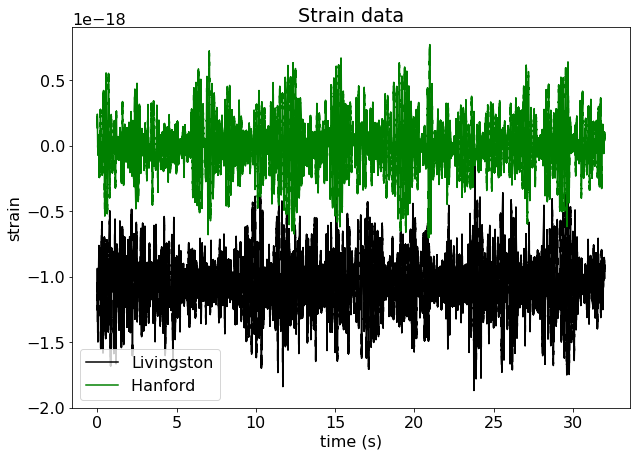

In [25]:
timeL = np.linspace(0, len(strainL), len(strainL))*dtL
timeH = np.linspace(0, len(strainH), len(strainH))*dtH

plt.plot(timeL, strainL, color='black', label='Livingston')
plt.plot(timeH, strainH, color='green', label='Hanford ')
plt.ylabel('strain')
plt.xlabel('time (s)')
plt.legend()
plt.title('Strain data')
plt.show()

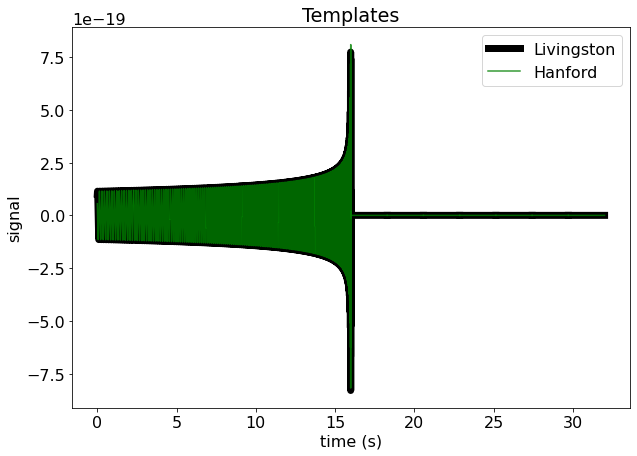

In [26]:
plt.plot(timeL, tL, linewidth=7, color='black', label='Livingston')
plt.plot(timeH, tH, color='green', label='Hanford', alpha=0.8, ms=2)
plt.ylabel('signal')
plt.xlabel('time (s)')
plt.legend()
plt.title('Templates')
plt.show()

# a) Noise Models

To determine a noise model for the Livingston and Hanford detectors, I used the smoothed power spectrum of the strain data for each of them. The first step was to window the data to avoid a large discontinuity from spraying power at all scales of the power spectrum. In order to do this, I used a tuckey window, which looked like it had a relatively flat section in the middle and dropped to 0 at the edges, meaning it would fix the power spraying issue but keep most of the signal in sections other than the edges. To apply the window, I multiplied the strain data by the window before taking the fourier transform. 

Then, by taking the square of the fourier transform, I had the power spectrum of the data. Looking at the first plot below, it is clear that even though we have some real spikes, a lot of the values especially at higher frequencies take up a large range. To fix this, I smoothed the power spectrum by convolving with a gaussian. I found that using $\sigma = 2$, there is nice smoothing without loosing the amplitudes of the spikes which we want to keep in the noise model. This seemed to work well with all events and for both detectors. Since this method did not seem to impact the lines very much, I assumed it was enough and didn't require more attention specifically for the lines. The second plot shows the smoothed out power spectrum for the first event as an example. 

In [27]:
def smooth_vector(vec, sig):
    n=len(vec)
    x=np.arange(n)
    x[n//2:]=x[n//2:]-n
    kernel=np.exp(-0.5*x**2/sig**2) #make a Gaussian kernel
    kernel=kernel/kernel.sum()
    vecft=np.fft.rfft(vec)
    kernelft=np.fft.rfft(kernel)
    vec_smooth=np.fft.irfft(vecft*kernelft) #convolve the data with the kernel
    return vec_smooth

In [28]:
# creating a window function
x = np.linspace(-np.pi/2,np.pi/2,len(strainL))
win = signal.tukey(len(x))

In [29]:
# getting the frequency range
dfreq = 1/timeL[-1]
freq = np.arange(len(strainL))*dfreq

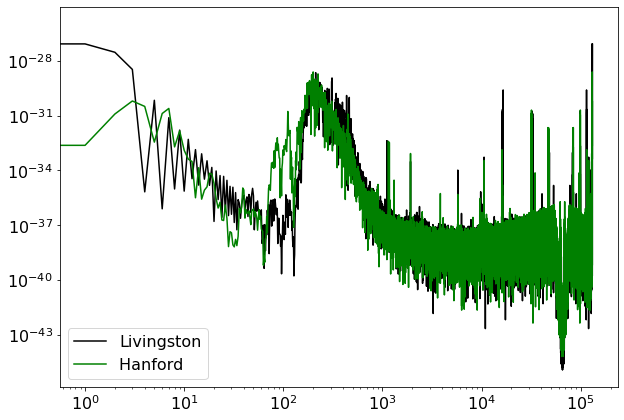

In [30]:
# getting the power spectrum
ps_L = np.abs(np.fft.fft(strainL * win))**2
ps_H = np.abs(np.fft.fft(strainH * win))**2
plt.loglog(ps_L, color='black', label='Livingston')
plt.loglog(ps_H, color='green', label='Hanford ')
plt.legend()
plt.show()

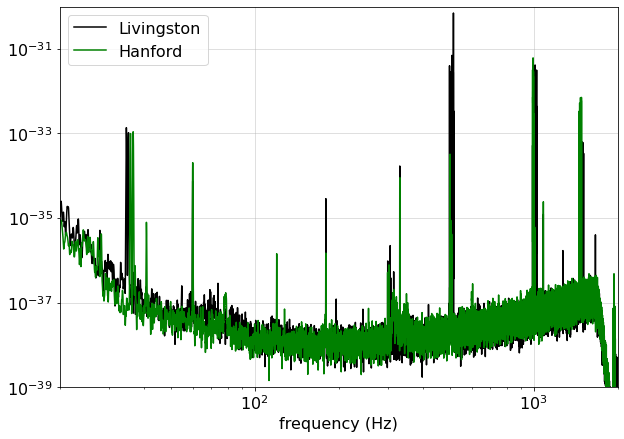

In [31]:
# smoothing
psL_smooth=smooth_vector(ps_L, 2)
psH_smooth=smooth_vector(ps_H, 2)

plt.loglog(freq, psL_smooth, color='black', label='Livingston')
plt.loglog(freq, psH_smooth, color='green', label='Hanford')
plt.xlim(20, 2000)
plt.ylim(1e-39, 1e-30)
plt.legend()
plt.xlabel('frequency (Hz)')
plt.grid(alpha=0.5)
plt.show()

# b) search for events with matched filters

Using the noise models, I used matched filters to search for the 4 events using the 4 templates provided. The first step was to pre-whiten the template and the data using the $N^{-1}$ matrix obtained by taking the reciprocal of the smoothed power spectrum. We also masked frequencies which noise blowing up or that contained a lot of digital filtering noise. After pre-whitening the data, we can see in the first plot below that the complex wavelike errors have been converted into simple white noise. Similarly, in the second plot, we see that the pre-whitened template now shows that the more significant signal will come from the frequencies just before the merger. 

Applying this pre-whitening has changed the fit into the following operations:

$$A^TAm = A^Td$$

Where the left hand side is simply a normalizing scalar and the right hand side involves the correlation of our pre-whitened data and templates in fourier space. After performing this, the output of the matched filter is shown in the third plot below. There is a very clear peak in the amplitude that looks statistically significant, which means we have been able to detect the GW event. 

After going through this example, I performed the same analysis for all 4 events and both detectors. The results are shown below.

In [32]:
NinvH=1/psH_smooth
NinvL=1/psL_smooth

NinvH[freq>1500]=0 # digital filtering noise
NinvH[freq<20]=0  # blows up lower than this
NinvL[freq>1500]=0
NinvL[freq<20]=0

In [33]:
# fourier transform and whitened template
template_ft = np.fft.fft(tH*win)
template_ft_white = template_ft * np.sqrt(NinvH)
template_white = template_white = np.fft.ifft(template_ft_white)

# fourier transform and whitened data
data_ft = np.fft.fft(strainH*win)
data_ft_white = data_ft * np.sqrt(NinvH)
data_white = np.fft.ifft(data_ft_white)

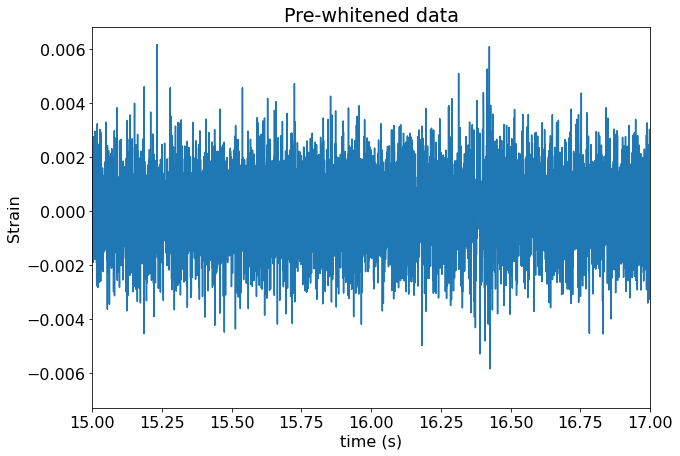

In [34]:
plt.plot(timeH, np.real(data_white))
plt.title('Pre-whitened data')
plt.ylabel('Strain')
plt.xlim(15, 17)
plt.xlabel('time (s)')
plt.show()

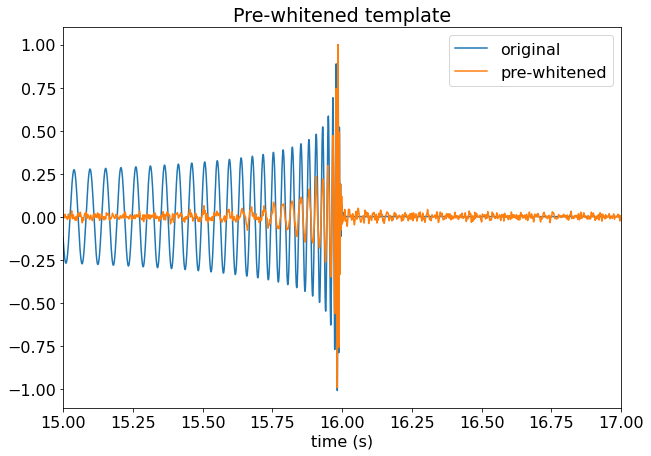

In [35]:
plt.plot(timeH, np.real(tH/tH.max()), label='original')
plt.plot(timeH, np.real(template_white/template_white.max()), label='pre-whitened')
plt.title('Pre-whitened template')
plt.xlim(15, 17)
plt.xlabel('time (s)')
plt.legend()
plt.show()

In [36]:
rhs = np.real(np.fft.ifft(data_ft_white * np.conj(template_ft_white)))
lhs = np.real(template_ft_white.T @ template_ft_white)
mf = rhs / lhs

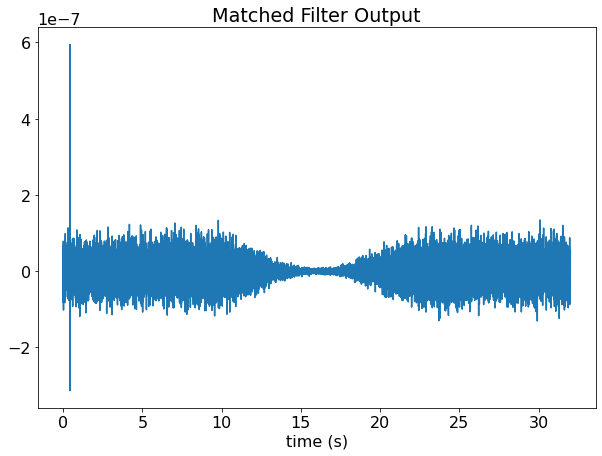

In [37]:
plt.plot(timeH, mf)
plt.title('Matched Filter Output')
plt.xlabel('time (s)')
plt.show()

## Repeating for all 4 events

In [38]:
def match_filter_fun(fnameH, fnameL, tname, sig):
    
    # loading the files
    print('reading files\n',fnameH, '\n', fnameL)
    strainH,dtH,utcH=read_file(fnameH)
    strainL,dtL,utcL=read_file(fnameL)
    print('reading template \n',tname)
    tH,tL=read_template(tname)
    
    # creating window function
    x = np.linspace(-np.pi/2,np.pi/2,len(strainL))
    win = signal.tukey(len(x))
    
    # estimating power spectrum
    ps_L = np.abs(np.fft.fft(strainL * win))**2 / np.size(win)
    ps_H = np.abs(np.fft.fft(strainH * win))**2 / np.size(win)
    
    # smoothing power spectrum
    psL_smooth=smooth_vector(ps_L, sig) 
    psH_smooth=smooth_vector(ps_H, sig) 
    
    # getting noise mode
    NinvL=1/psL_smooth
    NinvH=1/psH_smooth
    NinvH[freq>1500]=0
    NinvH[freq<20]=0  
    NinvL[freq>1500]=0
    NinvL[freq<20]=0
    
    # pre-whitening our template and data
    template_ftH=np.fft.fft(tH*win)
    template_ft_whiteH = template_ftH * np.sqrt(NinvH)
    template_ftL=np.fft.fft(tL*win)
    template_ft_whiteL = template_ftL * np.sqrt(NinvL)

    data_ftH=np.fft.fft(strainH*win)
    data_ft_whiteH = data_ftH * np.sqrt(NinvH)
    data_ftL=np.fft.fft(strainL*win)
    data_ft_whiteL = data_ftL * np.sqrt(NinvL)
    
    # making the match filters
    rhsH = np.real(np.fft.ifft(data_ft_whiteH * np.conj(template_ft_whiteH)))
    lhsH = np.real(template_ft_whiteH.T @ template_ft_whiteH)
    mfH = rhsH / lhsH
    
    rhsL = np.real(np.fft.ifft(data_ft_whiteL * np.conj(template_ft_whiteL)))
    lhsL = np.real(template_ft_whiteL.T @ template_ft_whiteL)
    mfL = rhsL / lhsL
    
    return mfH, lhsH, NinvH, mfL, lhsL, NinvL

reading files
 ./LOSC_Event_tutorial-master/H-H1_LOSC_4_V2-1126259446-32.hdf5 
 ./LOSC_Event_tutorial-master/L-L1_LOSC_4_V2-1126259446-32.hdf5
reading template 
 ./LOSC_Event_tutorial-master/GW150914_4_template.hdf5


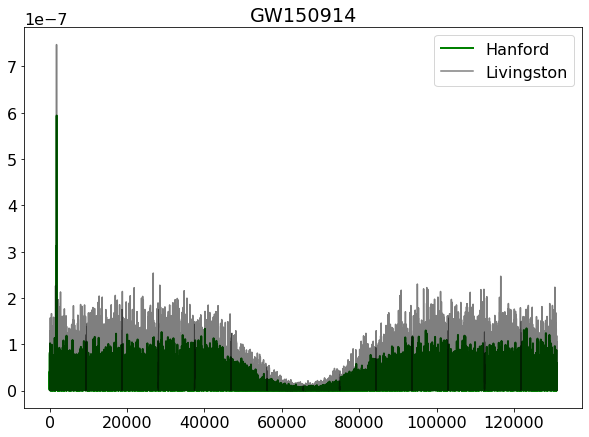

reading files
 ./LOSC_Event_tutorial-master/H-H1_LOSC_4_V2-1128678884-32.hdf5 
 ./LOSC_Event_tutorial-master/L-L1_LOSC_4_V2-1128678884-32.hdf5
reading template 
 ./LOSC_Event_tutorial-master/LVT151012_4_template.hdf5


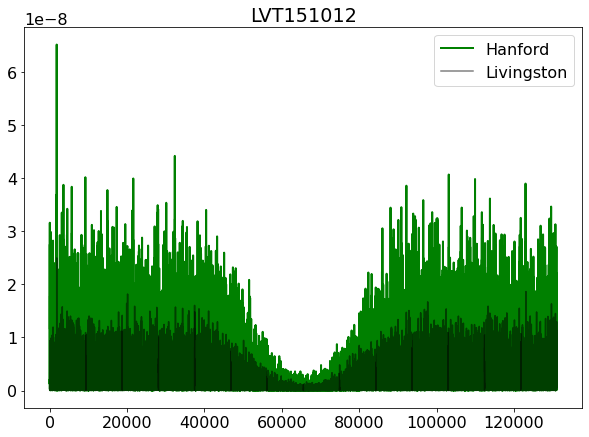

reading files
 ./LOSC_Event_tutorial-master/H-H1_LOSC_4_V2-1135136334-32.hdf5 
 ./LOSC_Event_tutorial-master/L-L1_LOSC_4_V2-1135136334-32.hdf5
reading template 
 ./LOSC_Event_tutorial-master/GW151226_4_template.hdf5


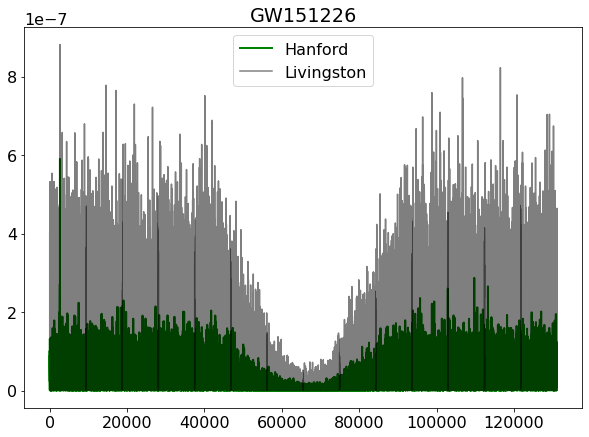

reading files
 ./LOSC_Event_tutorial-master/H-H1_LOSC_4_V1-1167559920-32.hdf5 
 ./LOSC_Event_tutorial-master/L-L1_LOSC_4_V1-1167559920-32.hdf5
reading template 
 ./LOSC_Event_tutorial-master/GW170104_4_template.hdf5


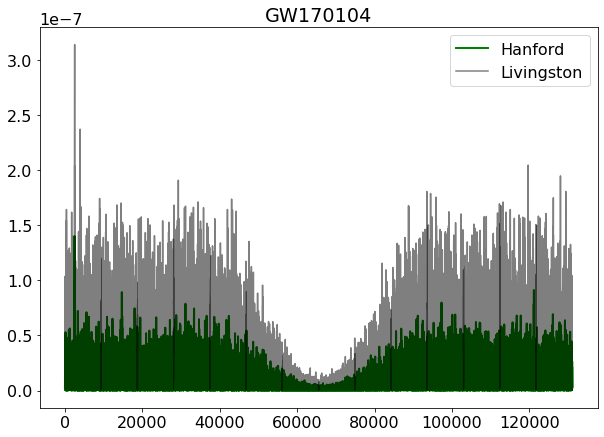

In [39]:
mfs = []
lhss = []
Ninvs = []


filenames = [directory + 'H-H1_LOSC_4_V2-1126259446-32.hdf5', directory + 'L-L1_LOSC_4_V2-1126259446-32.hdf5']
template_name = directory + 'GW150914_4_template.hdf5'
mfH, lhsH, NinvH, mfL, lhsL, NinvL = match_filter_fun(filenames[0], filenames[1], template_name, 2)
mfs.append([mfH, mfL])
lhss.append([lhsH, lhsL])
Ninvs.append([NinvH, NinvL])
plt.plot(np.abs(mfH), linewidth=2, color='green', label='Hanford')
plt.plot(np.abs(mfL), alpha=0.5, color='black', label='Livingston')
plt.legend()
plt.title('GW150914')
plt.show()

filenames = [directory + 'H-H1_LOSC_4_V2-1128678884-32.hdf5', directory + 'L-L1_LOSC_4_V2-1128678884-32.hdf5']
template_name = directory + 'LVT151012_4_template.hdf5'
mfH, lhsH, NinvH, mfL, lhsL, NinvL = match_filter_fun(filenames[0], filenames[1], template_name, 2)
mfs.append([mfH, mfL])
lhss.append([lhsH, lhsL])
Ninvs.append([NinvH, NinvL])
plt.plot(np.abs(mfH), linewidth=2, color='green', label='Hanford')
plt.plot(np.abs(mfL), alpha=0.5, color='black', label='Livingston')
plt.legend()
plt.title('LVT151012')
plt.show()

filenames = [directory + 'H-H1_LOSC_4_V2-1135136334-32.hdf5', directory + 'L-L1_LOSC_4_V2-1135136334-32.hdf5']
template_name = directory + 'GW151226_4_template.hdf5'
mfH, lhsH, NinvH, mfL, lhsL, NinvL = match_filter_fun(filenames[0], filenames[1], template_name, 2)
mfs.append([mfH, mfL])
lhss.append([lhsH, lhsL])
Ninvs.append([NinvH, NinvL])
plt.plot(np.abs(mfH), linewidth=2, color='green', label='Hanford')
plt.plot(np.abs(mfL), alpha=0.5, color='black', label='Livingston')
plt.legend()
plt.title('GW151226')
plt.show()

filenames = [directory + 'H-H1_LOSC_4_V1-1167559920-32.hdf5', directory + 'L-L1_LOSC_4_V1-1167559920-32.hdf5']
template_name = directory + 'GW170104_4_template.hdf5'
mfH, lhsH, NinvH, mfL, lhsL, NinvL = match_filter_fun(filenames[0], filenames[1], template_name, 2)
mfs.append([mfH, mfL])
lhss.append([lhsH, lhsL])
Ninvs.append([NinvH, NinvL])
plt.plot(np.abs(mfH), linewidth=2, color='green', label='Hanford')
plt.plot(np.abs(mfL), alpha=0.5, color='black', label='Livingston')
plt.legend()
plt.title('GW170104')
plt.show()

Ninvs = np.array(Ninvs)

# c) signal-to-noise ratios

I estimated the noise for each event by looking at the scatter of the matched filter output away from both the peak and the dip caused by the windowing. With that, I could estimate the signal-to-noise ratio (SNR) for the 4 events in both detectors separately. 

$$SNR_{1,H} = 16.99, \ \ \ \ \ \ \ \ \  SNR_{1,L} = 11.80$$
$$SNR_{2,H} = 6.47, \ \ \ \ \ \ \ \ \   SNR_{2,L} = 5.50$$
$$SNR_{3,H} = 9.65, \ \ \ \ \ \ \ \ \   SNR_{3,L} = 4.72$$
$$SNR_{4,H} = 7.09, \ \ \ \ \ \ \ \ \   SNR_{4,L} = 6.06$$

Using summation by quadrature, I also found the SNR of the detection when combining both detectors. The results I got were:

$$SNR_{1} = 20.74$$
$$SNR_{2} = 8.49$$
$$SNR_{3} = 10.74$$
$$SNR_{4} = 9.33$$


In [40]:
start, end = 90000, 125000
SNRs = []
for event in mfs:
    eH, eL = event[0], event[1]
    SNR_H = np.max(np.abs(eH)) / np.std(eH[start:end])
    SNR_L = np.max(np.abs(eL)) / np.std(eL[start:end])
    SNRs.append([SNR_H, SNR_L])
    
SNRs

[[16.99157153986351, 11.895137035420742],
 [6.471844672701312, 5.502198720734452],
 [9.65069179528064, 4.715050452545381],
 [7.0948731460905465, 6.064769308000081]]

In [41]:
combined_SNR = []
for el in SNRs:
    c = np.sqrt(el[0]**2 + el[1]**2)
    combined_SNR.append(c)
    
combined_SNR

[20.74145097349117, 8.494643266790208, 10.740928865677562, 9.333737285695188]

# d) analytical SNRs

From the model we can get the analytical expected errors of the matched filter amplitude output by taking:

$$error = \frac{1}{\sqrt{A^TA}}$$

Using this error instead, the values for SNR that I got were:

$$SNR_{1,H} = 10.45, \ \ \ \ \ \ \ \ \   SNR_{1,L} = 9.27$$
$$SNR_{2,H} = 1.76, \ \ \ \ \ \ \ \ \   SNR_{2,L} = 0.95$$
$$SNR_{3,H} = 5.39, \ \ \ \ \ \ \ \ \   SNR_{3,L} = 3.82$$
$$SNR_{4,H} = 3.03, \ \ \ \ \ \ \ \ \   SNR_{4,L} = 4.70$$

$$SNR_{1} = 13.97$$
$$SNR_{2} = 2.00$$
$$SNR_{3} = 6.61$$
$$SNR_{4} = 5.59$$

Comparing these values with what we got using the scatter of the matched filter output, it seems that my noise model is overestimating the errors in the data. I assumed this because it produces a smaller SNR in all cases when compared to the SNR derived from the scatter on the data. Maybe this means that I could have smoothed the power spectrum in a more careful way, or they might also be some normalization errors that cause a mismatch between the estimate of the peak of the matched filter and the analytical error. 

In [42]:
# analytical errors
SNRs_analytical = []
for i, lhs in enumerate(lhss):
    H, L = lhs[0], lhs[1]
    mH, mL = mfs[i][0], mfs[i][1]
    errH = 1/np.sqrt(np.abs(H)) * dfreq
    errL = 1/np.sqrt(np.abs(L)) * dfreq
    SNRH = np.max(np.abs(mH)) / errH
    SNRL = np.max(np.abs(mL)) / errL
    SNRs_analytical.append([SNRH, SNRL])
    
SNRs_analytical

[[10.452461247149435, 9.267104886041338],
 [1.7641514591750755, 0.9510428995388674],
 [5.386944457756299, 3.822665959473757],
 [3.032076053545012, 4.700204129628244]]

In [43]:
combined_analytical = []
for el in SNRs_analytical:
    c = np.sqrt(el[0]**2 + el[1]**2)
    combined_analytical.append(c)
    
combined_analytical

[13.969007806285024, 2.004173886585903, 6.605448177729557, 5.593335682279001]

# e) half-way frequency

To find the frequency where half of the weight comes from above and half comes from below the frequency, I looked at the noise model matrices. This is because the weight comes from the noise at each value of the frequency in fourier space, as the noise model will be uncorrelated in this space. The results I got are printed below, but for clarity are shown here:

- GW150914 $\ \ \ \ \ \ \ \ \ \ \ \  $$\longrightarrow$
$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $Hanford = 408.625 Hz   $\ \ \ \ \ \ \ \ \ \ \ \ \ \ \$        Livingston = 431.5 Hz

- LVT151012 $\ \ \ \ \ \ \ \ \ \ \ \  $$\longrightarrow$
$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $Hanford = 405.656 Hz $\ \ \ \ \ \ \ \ \ \ \ \ \ \ $        Livingston = 403.03125 Hz

- GW151226 $\ \ \ \ \ \ \ \ \ \ \ \  $$\longrightarrow$
$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $Hanford = 377.594 Hz $\ \ \ \ \ \ \ \ \ \ \ \ \ \ $ Livingston = 419.28125 Hz

- GW170104 $\ \ \ \ \ \ \ \ \ \ \ \  $$\longrightarrow$
$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $Hanford = 421.5 Hz $\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $  Livingston = 387.375 Hz

In [44]:
events = ['GW150914', 'LVT151012', 'GW151226', 'GW170104']

In [45]:
def half_weight(Ninv):
    
    right = np.sum(Ninv)
    left = 0.0
    i, j = 0, 1
    while j < len(Ninv) :
        right -= Ninv[j]
        left += Ninv[i]
         
        # check if left sum has gone past or is equation to the right one
        if left >= right:
            return i        
        j += 1
        i += 1
 
    return None

In [46]:
for i, N in enumerate(Ninvs):
    NH, NL = N[0], N[1]
    halfH, halfL = half_weight(NH), half_weight(NL)
    print(events[i])
    print('Hanford = {} Hz, Livingston = {} Hz'.format(freq[halfH], freq[halfL]))
    print()

GW150914
Hanford = 408.625 Hz, Livingston = 431.5 Hz

LVT151012
Hanford = 405.65625 Hz, Livingston = 403.03125 Hz

GW151226
Hanford = 377.59375 Hz, Livingston = 419.28125 Hz

GW170104
Hanford = 421.5 Hz, Livingston = 387.375 Hz



# f) localizing the event

We can localize the event to an accuracy given by the time resolution,

$$dt = 0.000244140625 s$$

From the matched filters at Hanford and Livingston, we see that the time shift for our template to align with the signal from the strain data for the first event are:

$$t_H = 0.4404s \ \ \ \ \ \ \ \ \ \ \ \ \ t_L = 0.4316$$

Comparing their arrival times we get that the arrival time difference is given by:

$$t_{diff} = 0.00879 \pm 0.00035 s$$

Where we propagated the error given by the maximum accuracy of determining the times for each detector. 

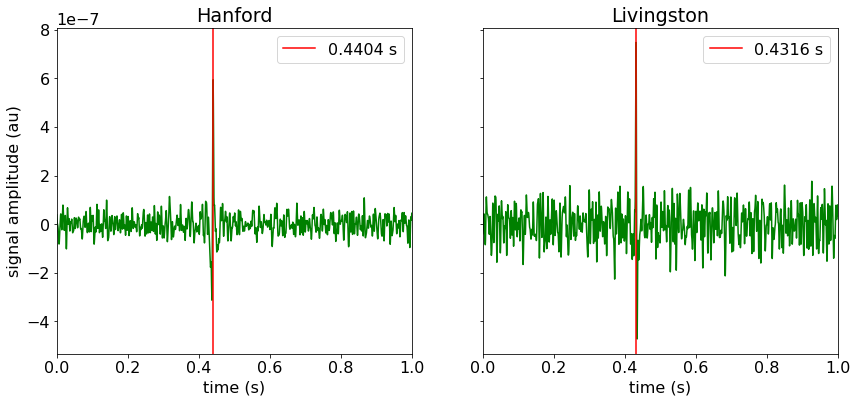

In [47]:
# getting the horizontal shift of the matched filters
indmax = np.argmax(mfs[0][0])
timemaxH = timeH[indmax]
shift_errorH = dtH

indmax = np.argmax(mfs[0][1])
timemaxL = timeL[indmax]
shift_errorL = dtL

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6), sharey=True, squeeze=True)

ax[0].plot(timeH, mfs[0][0], color='green')
ax[0].axvline(timemaxH, color='red', label='{} s'.format(round(timemaxH, 4)))
ax[0].set_xlim(0, 1)
ax[0].legend()
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('signal amplitude (au)')
ax[0].set_title('Hanford')

ax[1].plot(timeL, mfs[0][1], color='green')
ax[1].axvline(timemaxL, color='red', label='{} s'.format(round(timemaxL, 4)))
ax[1].set_xlim(0, 1)
ax[1].legend()
ax[1].set_xlabel('time (s)')
ax[1].set_title('Livingston')
plt.show()

In [48]:
# comparing arrival times on detectors

time_diff = np.abs(timemaxH - timemaxL)
err_time_diff = np.sqrt(shift_errorH**2 + shift_errorL**2)
print('arrival time difference = {} +/- {} s'.format(round(time_diff,5), round(err_time_diff, 5)))

arrival time difference = 0.00879 +/- 0.00035 s
